In [1]:
region_name = "TDS" # _ELAISN1
srcs_ids = [15179]  #RR*s [2052 ,15179 ,15934]

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

from regions import CircleSkyRegion
from astropy import units as uu
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.timeseries import LombScargle
from astropy.units import cds
cds.enable()  
import numpy as np

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from vasca.utils import mag2flux, sel_sources, dd_filter2id

region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
sel_src = rg.tt_sources["sel"]
tt_src = rg.tt_sources[sel_src]
display(tt_src[:2])

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32
-1,46 .. 5,334.64049826925117,0.4526866937010489,0.09875569,-0.23671262,0.2647861,0.9968758,0.5008254,14,0.08471,1 .. 2,True,9.525185 .. 5.7065663,0.13788767 .. 0.29823554,0.036390573 .. 0.013060489,4.2145147 .. 0.9072336,1.1285862e-24 .. 0.14995933,4.8611155 .. 1.6863966,0.9958173 .. 0.9101466,-0.22837132 .. -1.1546247,-1,8,4
-1,72 .. 5,334.60403128211425,0.40736589666436374,0.06406002,-0.17132753,0.15922262,0.99998045,0.45087305,23,0.14243871,1 .. 2,True,70.01522 .. 3.1264899,0.19698732 .. 0.23375492,0.00093811314 .. 0.013469439,7.4774384 .. 0.49470344,1.256716e-12 .. 0.27841964,2.6584294 .. 1.2719177,0.9798159 .. 0.954735,-5.3000717 .. -0.42171407,-1,13,4


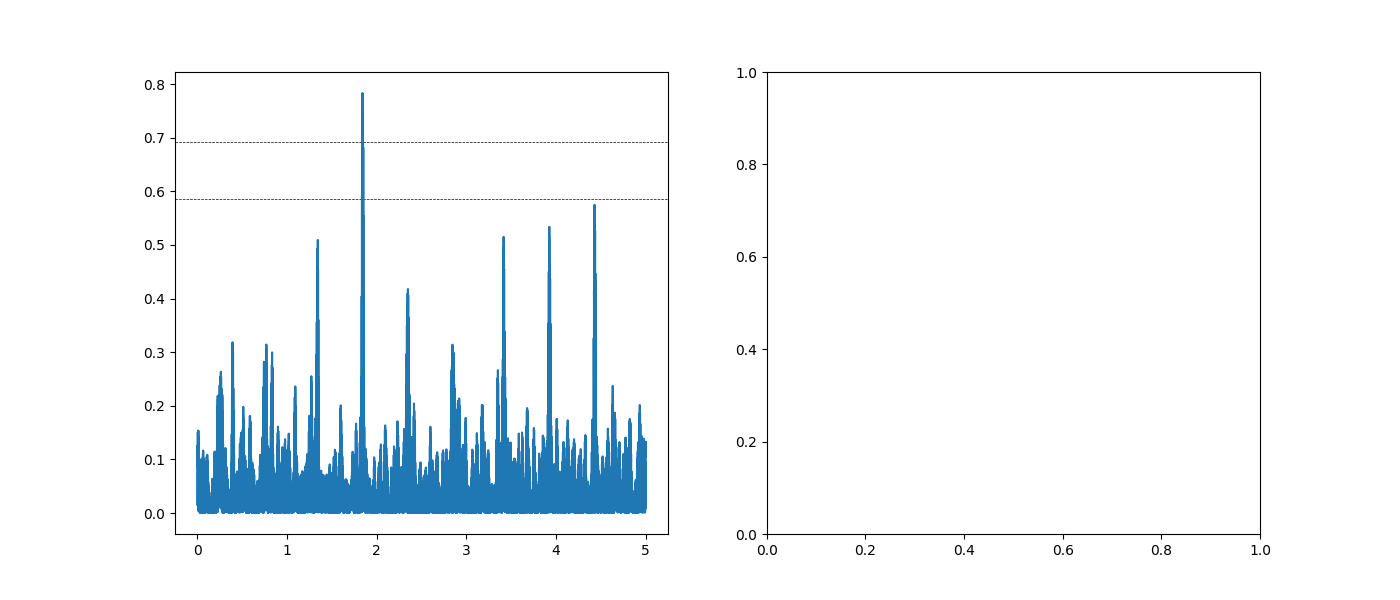

In [3]:
#from astropy.visualization import quantity_support
#quantity_support()
from astropy.timeseries import TimeSeries,BinnedTimeSeries
from astropy.table import QTable
from astropy.time import Time

dd_lcs = rg.get_light_curve(rg_src_ids=srcs_ids)
probabilities = [0.002699796063,0.000063342484] # 3 and 4 sigma
for src_id in dd_lcs.keys():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs = axs.flatten()
    plt.sca(axs[0])
    lc = dd_lcs[src_id][dd_lcs[src_id]["obs_filter_id"]==1]
    lc["time"]=Time(lc["time"].quantity, format="mjd")

    ts = TimeSeries(data=lc)
    
    ls = LombScargle(lc["time"], lc["flux"],lc["flux_err"])

    #Frquency vs power plot with confidence itnervals
    freq,power = ls.autopower(maximum_frequency=5/uu.d) #minimum_frequency=0.01/uu.d,
    conf = ls.false_alarm_level(probabilities)  
    plt.axhline(conf[0],linewidth=0.5, ls="--", color='k')
    plt.axhline(conf[1],linewidth=0.5, ls="--", color='k')
    plt.plot(freq, power)
    plt.show()
    

    #Show best fit model
    plt.sca(axs[1])
    best_freq = freq[np.argmax(power)]
    ts_folded = ts.fold(period=1/best_freq, epoch_time=lc["time"][0])
    plt.plot(ts_folded.time.jd, ts_folded['flux'], 'k.', markersize=4)
    plt.xlabel('Time (days)')
    plt.ylabel('Flux')
    
    #time_fit = np.linspace(0, 1)*uu.d
    #flux_fit = ls.model(time_fit*uu.d, best_freq)
    #plt.sca(axs[1])
    #plt.plot(time_fit,flux_fit,"ob")
    #plt.show()
    
    #fig = plt.figure(figsize=(14, 6))
    #vvis.plot_light_curve(rg,rg_src_ids = src_id, fig=fig)
    #plt.show()